# IBM's Superconducting Quantum Computer Model

## 1. Setup and Dependencies

<div style="background-color: #e8f8f0; padding: 15px; border-left: 5px solid #27ae60; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <h2 style="color: #2c3e50;">Environment Setup</h2>

  <p style="font-size: 14px; color: #34495e;">
    Install required libraries and set up the environment for quantum simulations using IBM's quantum superconducting architecture noise model.
  </p>

</div>

In [4]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import seaborn as sns
from math import comb 

# Save your IBM Quantum account (run this once)
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="GIt-Hr7Vo-5ok2DRPm3P1zUam5g84UfiS5BI_vYF3bDe",
    overwrite=True
)

# Styling for plots
sns.set()

## 2. Quantum Galton Board

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Quantum Galton Board (n-layer, Base Noisy)</h2>
  <p>
    We model a n-layer Quantum Galton Board using (2 * layer + 1) + 1 qubits to approximate a binomial distribution, simulating it with IBM's ibm_brisbane back end. This section shows the base noisy circuit without optimization.
  </p>
</div>

## 3. Optimization Technique: 

### 3.2 Dynamical Decoupling

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">ZNE for Quantum Galton Board</h2>
  <p>
    Zero-noise extrapolation (ZNE) lets us estimate how the QGB would behave without hardware noise, without changing the algorithm. We rerun the same circuit at deliberately higher noise via gate folding—duplicating H, CX, and CSWAP so depth (and therefore noise) increases while the ideal unitary stays the same. We use fold factors 1, 3, and 5, then fit those results back to the zero-noise point. The circuit is a standard Quantum Galton Board: an ancilla “coin” steers a CSWAP peg lattice so exactly one bin should light up at the end. We simulate with an IBM noise model when available (ibm_brisbane via QiskitRuntimeService), or fall back to a configured GenericBackendV2; either way, we run through AerSimulator and transpile for the chosen backend. From measurement counts, we keep one-hot outcomes (exactly one ‘1’) as the bin probabilities and treat everything else as error mass. For each bin (k), we fit a simple line (p_k(f)) across the fold factors and take the intercept as the zero-noise estimate (clipped at 0). We then compare raw vs ZNE-extrapolated distributions to the classical binomial target (fair coin) and report KL divergence. If the extrapolation looks jittery, bump shots or adjust the fold set.
  </p>
</div>

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-09 22:00:10,835: Default instance not set. Searching all available instances.


Using noise model from open-access IBM backend: ibm_brisbane (127 qubits)
No ZNE - Bin Probabilities: [0.0189, 0.0802, 0.1106, 0.0907, 0.0494, 0.0286], Error Prob: 0.6215999999999999, KL Divergence: 0.04197744039159543
With ZNE - Bin Probabilities: [0.01983333333333333, 0.07778333333333329, 0.10949999999999993, 0.08980833333333327, 0.05119166666666664, 0.02954999999999999], Error Prob: 0.6223333333333336, KL Divergence: 0.04293514209688074
Theoretical Binomial: [0.03125, 0.15625, 0.3125, 0.3125, 0.15625, 0.03125], Sum: 1.0


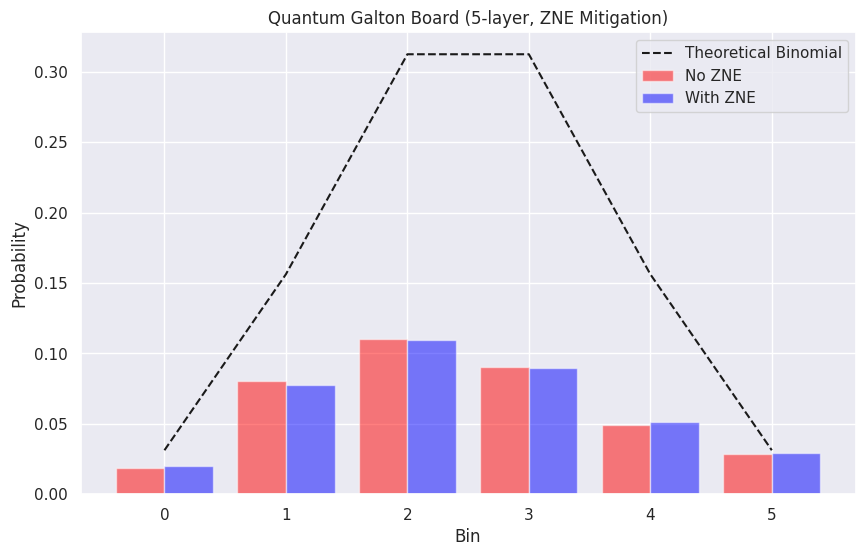

In [20]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.compiler import transpile
from qiskit.providers.fake_provider import GenericBackendV2
from scipy.stats import entropy
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

# Parameters
layers = 5
bins = layers + 1
n_qubits = 2 * layers + 2  # 2n + 1 working + 1 ancilla
n_bits = bins
shots = 10000
noise_factors = [1, 3, 5]  # ZNE scaling factors

# QGB circuit
def create_galton_board(layers):
    bins = layers + 1
    n_qubits = (2 * layers + 1) + 1
    n_bits = bins
    qc = QuantumCircuit(n_qubits, n_bits)
    ancilla = 0
    ball = bins
    state_0 = [1, 0]

    def pegs(layer, qc):
        if layer != 1:
            qc.initialize(state_0, ancilla)
            qc.h(ancilla)
        else:
            qc.h(ancilla)
            qc.x(ball)
        for j in range(2 * layer - 1):
            base = ball - layer + j
            qc.cswap(ancilla, base, base + 1)
            qc.cx(base + 1, ancilla)
        base = ball + layer
        qc.cswap(ancilla, base - 1, base)

    for i in range(1, layers + 1):
        pegs(i, qc)
    for i in range(bins):
        qc.measure(2 * i + 1, i)
    return qc

# Manual gate folding for ZNE
def fold_circuit(qc, factor):
    if factor == 1:
        return qc
    folded_qc = QuantumCircuit(qc.num_qubits, qc.num_clbits)
    folded_qc.data = []
    for inst in qc.data:
        folded_qc.append(inst)
        # Insert identity pairs for folding (factor-1 times)
        if inst.operation.name in ['h', 'cx', 'cswap']:
            for _ in range(factor - 1):
                folded_qc.append(inst)
                if inst.operation.name == 'h':
                    folded_qc.h(inst.qubits[0])  # H * H = I
                elif inst.operation.name == 'cx':
                    folded_qc.cx(*inst.qubits)  # CX * CX = I
                elif inst.operation.name == 'cswap':
                    folded_qc.cswap(*inst.qubits)  # CSWAP * CSWAP = I
    return folded_qc

qc_galton = create_galton_board(layers)

# Set up noise model from open-access IBM backend
try:
    service = QiskitRuntimeService(channel="ibm_quantum_platform")
    backend = service.backend("ibm_brisbane")  # 127 qubits, open-access
    if backend.configuration().n_qubits < n_qubits:
        raise ValueError(f"{backend.name} has only {backend.configuration().n_qubits} qubits, need {n_qubits}")
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from open-access IBM backend: {backend.name} ({backend.configuration().n_qubits} qubits)")
except Exception as e:
    print(f"Failed to access ibm_brisbane: {e}")
    print("Falling back to GenericBackendV2 with custom noise")
    backend = GenericBackendV2(
        num_qubits=n_qubits,
        basis_gates=['h', 'cx', 'swap', 'x'],
        coupling_map=[[i, i+1] for i in range(n_qubits-1)],
        gate_error_1q=0.001,
        gate_error_2q=0.01,
        t1=50e3,
        t2=50e3,
        gate_duration_1q=50,
        gate_duration_2q=200,
        readout_error=0.02
    )
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from GenericBackendV2 with {n_qubits} qubits")

# Transpile base circuit
transpiled_qc = transpile(qc_galton, backend, optimization_level=2)

# ZNE: Manual gate folding and simulation
simulator = AerSimulator(noise_model=noise_model)
bin_probs_list = []
error_probs = []

for factor in noise_factors:
    # Fold and transpile
    folded_qc = fold_circuit(transpiled_qc, factor)
    folded_transpiled_qc = transpile(folded_qc, backend, optimization_level=2)
    
    # Simulate
    result = simulator.run(folded_transpiled_qc, shots=shots).result()
    counts = result.get_counts()
    
    # Process probabilities
    bin_probs = np.zeros(bins)
    error_prob = 0.0
    for state, count in counts.items():
        if state.count('1') == 1:
            bin_index = state[::-1].index('1')
            bin_probs[bin_index] += count / shots
        else:
            error_prob += count / shots
    bin_probs_list.append(bin_probs)
    error_probs.append(error_prob)

# ZNE extrapolation (linear fit for each bin)
bin_probs_zne = np.zeros(bins)
for k in range(bins):
    probs_k = [bin_probs[k] for bin_probs in bin_probs_list]
    coeffs = np.polyfit(noise_factors, probs_k, 1)  # Linear fit
    bin_probs_zne[k] = max(coeffs[1], 0)  # Intercept (zero-noise), ensure non-negative

# No-ZNE (use factor=1 results)
bin_probs_no_zne = bin_probs_list[0]
error_prob_no_zne = error_probs[0]
error_prob_zne = 1 - np.sum(bin_probs_zne)  # Approximate error prob

# Theoretical binomial probabilities
p = 0.5  # Fair coin for classical QGB
k = np.arange(bins)
target_probs = np.array([comb(layers, i) * (p ** i) * ((1 - p) ** (layers - i)) for i in k])
target_probs /= target_probs.sum()  # Normalize

# KL divergence
epsilon = 1e-10
kl_no_zne = entropy(target_probs, bin_probs_no_zne + epsilon)
kl_zne = entropy(target_probs, bin_probs_zne + epsilon)

# Print results
print(f"No ZNE - Bin Probabilities: {bin_probs_no_zne.tolist()}, Error Prob: {error_prob_no_zne}, KL Divergence: {kl_no_zne}")
print(f"With ZNE - Bin Probabilities: {bin_probs_zne.tolist()}, Error Prob: {error_prob_zne}, KL Divergence: {kl_zne}")
print(f"Theoretical Binomial: {target_probs.tolist()}, Sum: {np.sum(target_probs)}")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(np.arange(bins) - 0.2, bin_probs_no_zne, width=0.4, label='No ZNE', color='red', alpha=0.5)
plt.bar(np.arange(bins) + 0.2, bin_probs_zne, width=0.4, label='With ZNE', color='blue', alpha=0.5)
plt.plot(np.arange(bins), target_probs, 'k--', label='Theoretical Binomial')
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title(f'Quantum Galton Board ({layers}-layer, ZNE Mitigation)')
plt.legend()
plt.show()